In [2]:
%load_ext autoreload
%autoreload 2

import json
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'yfinance'

## TODOS


- `Compare monthly rebalancing to daily (artificial) rebalancing`
- `Create different portfolios for momentum (ie. all longs, long-short)`
- `Change dates to include data from 1993 onwards`
- `ADDON: potfolio aggregation through IR`

In [233]:
f = open("params.json")
params = json.load(f)

data = yf.download(params['tickers'], start=params['start_date'], end=params['end_date'], auto_adjust=True)['Close']
data.head()

[*********************100%***********************]  10 of 10 completed


Ticker,AAPL,AMZN,GOOG,JNJ,JPM,META,MSFT,NVDA,TSLA,V
Date,,,,,,,,,,
2015-01-02,24.320427,15.4260,26.045292,78.681396,47.174252,78.081993,40.072121,0.483099,14.620667,61.672863
2015-01-05,23.635284,15.1095,25.502361,78.131874,45.709736,76.827919,39.703648,0.474939,14.006000,60.311527
2015-01-06,23.637512,14.7645,24.911291,77.747925,44.524529,75.792786,39.120892,0.460540,14.085333,59.922897
2015-01-07,23.968962,14.9210,24.868610,79.464294,44.592480,75.792786,39.617935,0.459340,14.063333,60.725765
2015-01-08,24.889902,15.0230,24.947021,80.089119,45.588959,77.813263,40.783417,0.476619,14.041333,61.540241


In [234]:
# load FF
ff = pd.read_csv("data/ff_daily.csv")

ff["Date"] = pd.to_datetime(ff["Date"].astype(str), format='%Y%m%d')
ff = ff.set_index("Date")
ff = ff / 100 # convert to percentage
ff

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07-01,0.0010,-0.0025,-0.0027,0.00009
1926-07-02,0.0045,-0.0033,-0.0006,0.00009
1926-07-06,0.0017,0.0030,-0.0039,0.00009
1926-07-07,0.0009,-0.0058,0.0002,0.00009
1926-07-08,0.0021,-0.0038,0.0019,0.00009
...,...,...,...,...
2024-12-24,0.0111,-0.0009,-0.0005,0.00017
2024-12-26,0.0002,0.0104,-0.0019,0.00017
2024-12-27,-0.0117,-0.0066,0.0056,0.00017


In [235]:
returns = data.pct_change().dropna()
returns

Ticker,AAPL,AMZN,GOOG,JNJ,JPM,META,MSFT,NVDA,TSLA,V
Date,,,,,,,,,,
2015-01-05,-0.028171,-0.020517,-0.020846,-0.006984,-0.031045,-0.016061,-0.009195,-0.016890,-0.042041,-0.022073
2015-01-06,0.000094,-0.022833,-0.023177,-0.004914,-0.025929,-0.013473,-0.014678,-0.030318,0.005664,-0.006444
2015-01-07,0.014022,0.010600,-0.001713,0.022076,0.001526,0.000000,0.012705,-0.002605,-0.001562,0.013398
2015-01-08,0.038422,0.006836,0.003153,0.007863,0.022346,0.026658,0.029418,0.037617,-0.001564,0.013412
2015-01-09,0.001072,-0.011749,-0.012950,-0.013629,-0.017387,-0.005628,-0.008405,0.004028,-0.018802,-0.014823
...,...,...,...,...,...,...,...,...,...,...
2024-12-23,0.003065,0.000622,0.015703,0.005538,0.003325,0.024947,-0.003092,0.036897,0.022657,-0.001542
2024-12-24,0.011478,0.017729,0.008062,0.003993,0.016444,0.013170,0.009374,0.003938,0.073572,0.010813
2024-12-26,0.003176,-0.008732,-0.002379,-0.001851,0.003425,-0.007240,-0.002777,-0.002068,-0.017630,0.000811


In [238]:
common = returns.index.intersection(ff.index)
ff = ff.loc[common]

xreturns = returns.subtract(ff['RF'], axis = 0)
xreturns

Ticker,AAPL,AMZN,GOOG,JNJ,JPM,META,MSFT,NVDA,TSLA,V
Date,,,,,,,,,,
2015-01-05,-0.028171,-0.020517,-0.020846,-0.006984,-0.031045,-0.016061,-0.009195,-0.016890,-0.042041,-0.022073
2015-01-06,0.000094,-0.022833,-0.023177,-0.004914,-0.025929,-0.013473,-0.014678,-0.030318,0.005664,-0.006444
2015-01-07,0.014022,0.010600,-0.001713,0.022076,0.001526,0.000000,0.012705,-0.002605,-0.001562,0.013398
2015-01-08,0.038422,0.006836,0.003153,0.007863,0.022346,0.026658,0.029418,0.037617,-0.001564,0.013412
2015-01-09,0.001072,-0.011749,-0.012950,-0.013629,-0.017387,-0.005628,-0.008405,0.004028,-0.018802,-0.014823
...,...,...,...,...,...,...,...,...,...,...
2024-12-23,0.002895,0.000452,0.015533,0.005368,0.003155,0.024777,-0.003262,0.036727,0.022487,-0.001712
2024-12-24,0.011308,0.017559,0.007892,0.003823,0.016274,0.013000,0.009204,0.003768,0.073402,0.010643
2024-12-26,0.003006,-0.008902,-0.002549,-0.002021,0.003255,-0.007410,-0.002947,-0.002238,-0.017800,0.000641


In [261]:
monthly_dates = xreturns.resample("MS").last().index
monthly_dates

DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01',
               ...
               '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01',
               '2024-07-01', '2024-08-01', '2024-09-01', '2024-10-01',
               '2024-11-01', '2024-12-01'],
              dtype='datetime64[ns]', name='Date', length=120, freq='MS')

In [ ]:
from pandas.tseries.offsets import MonthEnd

# momentum signal
momentum = pd.DataFrame()

for month in monthly_dates[13:]: # 12M excluding last month MOM12-2
    end = (month - pd.DateOffset(months = 2)) + MonthEnd(0)
    beg = (month - pd.DateOffset(months = 13)).replace(day = 1)
    
    # print(month, ": ", beg, "-", end)    
    
    retursn2Minus12 = xreturns[(xreturns.index >= beg) & (xreturns.index <= end)]
    retursn2Minus12 = retursn2Minus12 + 1
    mom = retursn2Minus12.prod() - 1

    momentum[month] = mom

momentum = momentum.T

/var/folders/bc/hnzwjdn546lcc572zg36k_vc0000gn/T/ipykernel_31652/268885079.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  momentum[month] = mom


In [296]:
momentum

Ticker,AAPL,AMZN,GOOG,JNJ,JPM,META,MSFT,NVDA,TSLA,V
2016-02-01,-0.020823,1.190749,0.449979,0.011906,0.078350,0.334098,0.218785,0.664514,0.094387,0.178697
2016-03-01,-0.155014,0.655713,0.393755,0.073850,0.124113,0.478198,0.400736,0.550823,-0.060904,0.177091
2016-04-01,-0.233515,0.453096,0.252768,0.056805,-0.056298,0.353660,0.191743,0.444569,-0.056302,0.074711
2016-05-01,-0.108222,0.594708,0.362558,0.107230,0.003897,0.387158,0.394818,0.729496,0.216686,0.177139
2016-06-01,-0.237413,0.563168,0.289163,0.163122,0.026749,0.492074,0.052824,0.625979,0.064629,0.177317
...,...,...,...,...,...,...,...,...,...,...
2024-08-01,0.035626,0.406501,0.440223,-0.136052,0.354412,0.670472,0.254963,1.772031,-0.282905,0.056684
2024-09-01,0.077962,0.326761,0.235272,-0.078337,0.310019,0.416615,0.190539,1.376366,-0.176964,0.068209
2024-10-01,0.161831,0.226535,0.141258,0.003578,0.493562,0.674311,0.215981,1.294542,-0.213347,0.075151
2024-11-01,0.297444,0.390334,0.205681,0.018127,0.413868,0.814192,0.302333,1.649200,-0.008316,0.142741


The following cell should be modified depending on the number of securities and whether we want to long only or we also want to short.

In [287]:
def top_equal_weights(row):
    top = row.nlargest(3).index
    weight = pd.Series(0, index = row.index)
    weight[top] = 1 / 3
    return weight

In [328]:
weights = momentum.apply(top_equal_weights, axis = 1)
weights

Ticker,AAPL,AMZN,GOOG,JNJ,JPM,META,MSFT,NVDA,TSLA,V
2016-02-01,0.0,0.333333,0.333333,0.0,0.000000,0.000000,0.000000,0.333333,0.0,0.0
2016-03-01,0.0,0.333333,0.000000,0.0,0.000000,0.333333,0.000000,0.333333,0.0,0.0
2016-04-01,0.0,0.333333,0.000000,0.0,0.000000,0.333333,0.000000,0.333333,0.0,0.0
2016-05-01,0.0,0.333333,0.000000,0.0,0.000000,0.000000,0.333333,0.333333,0.0,0.0
2016-06-01,0.0,0.333333,0.000000,0.0,0.000000,0.333333,0.000000,0.333333,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2024-08-01,0.0,0.000000,0.333333,0.0,0.000000,0.333333,0.000000,0.333333,0.0,0.0
2024-09-01,0.0,0.333333,0.000000,0.0,0.000000,0.333333,0.000000,0.333333,0.0,0.0
2024-10-01,0.0,0.000000,0.000000,0.0,0.333333,0.333333,0.000000,0.333333,0.0,0.0
2024-11-01,0.0,0.000000,0.000000,0.0,0.333333,0.333333,0.000000,0.333333,0.0,0.0


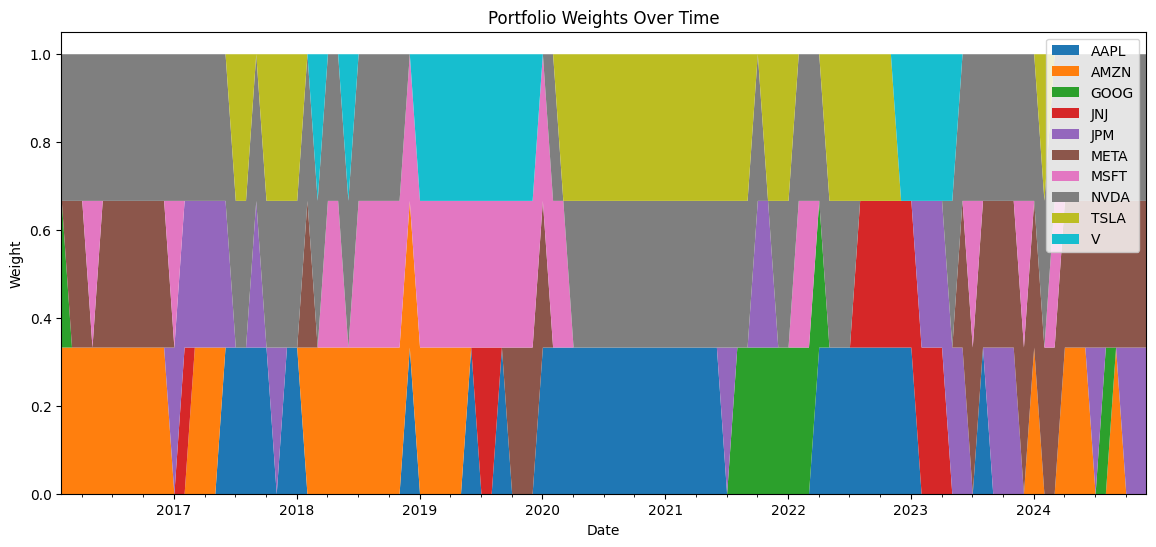

In [ ]:
weights.plot.area(figsize=(14, 6), linewidth=0)
plt.title('Portfolio Weights Over Time')
plt.ylabel('Weight')
plt.xlabel('Date')
plt.legend(loc='upper right')
plt.show()

In [394]:
portfolio = pd.DataFrame()

for month in weights.index:
    beg = month
    end = beg + MonthEnd(0)
    ret_month = xreturns.loc[beg:end] # filter the monthly returns for this period
    cum_month = (1 + ret_month).cumprod() # compute cum returns (no daily rebalancing)

    # adjust for equal weights in first trading day of month
    cum_month= cum_month.shift(1)
    cum_month.iloc[0] = 1

    ini_weight = weights.loc[month] # get initial weights for the period
    month_weights = cum_month.multiply(ini_weight, axis=1)
    
    ret_portfolio = (month_weights * ret_month).sum(axis = 1)
    portfolio = pd.concat([portfolio, ret_portfolio])
    
portfolio.columns = ["Portfolio Return"]
portfolio

,Portfolio Return
2016-02-01,-0.002758
2016-02-02,-0.021342
2016-02-03,-0.027273
2016-02-04,-0.005446
2016-02-05,-0.050611
...,...
2024-12-23,0.021298
2024-12-24,0.010947
2024-12-26,-0.002313
2024-12-27,-0.011862


<Axes: >

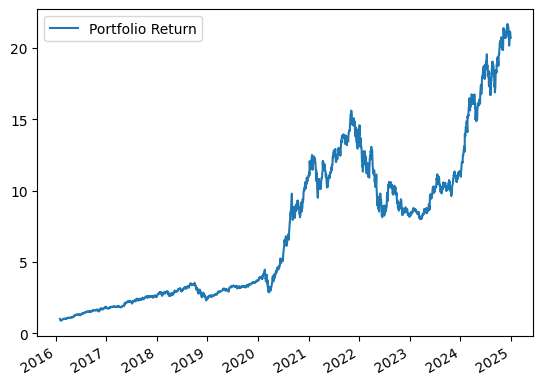

In [396]:
cum_returns = (1 + portfolio).cumprod()
cum_returns.plot()

In [408]:

mupor = portfolio.mean() * 252
sdpor = portfolio.std() * np.sqrt(252)
srpor = mupor / sdpor

print(f"Mu: {mupor[0]}")
print(f"Std: {sdpor[0]}")
print(f"Sharpe: {srpor[0]}")

Mu: 0.39113440348710693
Std: 0.31725981176101525
Sharpe: 1.2328520316394178


In [411]:
port_common = portfolio.index.intersection(ff.index)
port_ff = ff.loc[port_common]
port_ff

,Mkt-RF,SMB,HML,RF
2016-02-01,-0.0004,-0.0019,-0.0100,0.00001
2016-02-02,-0.0200,-0.0003,-0.0037,0.00001
2016-02-03,0.0046,-0.0033,0.0047,0.00001
2016-02-04,0.0027,0.0012,0.0035,0.00001
2016-02-05,-0.0206,-0.0107,0.0164,0.00001
...,...,...,...,...
2024-12-23,0.0061,-0.0070,-0.0019,0.00017
2024-12-24,0.0111,-0.0009,-0.0005,0.00017
2024-12-26,0.0002,0.0104,-0.0019,0.00017
2024-12-27,-0.0117,-0.0066,0.0056,0.00017


In [424]:
# regression
X = port_ff[['Mkt-RF', 'SMB', 'HML']]
y = portfolio

model = LinearRegression().fit(X, y)
alpha = model.intercept_
betas = model.coef_

In [426]:
print(f"Mu: {mupor[0]}")
print(f"Std: {sdpor[0]}")
print(f"Sharpe: {srpor[0]}")
print(f"Alpha Ann: {alpha[0] * 252}")
print(f"Beta to MKT: {betas[0][0]}")
print(f"Beta to SMB: {betas[0][1]}")
print(f"Beta to HML: {betas[0][2]}")

Mu: 0.39113440348710693
Std: 0.31725981176101525
Sharpe: 1.2328520316394178
Alpha Ann: 0.19791795161749756
Beta to MKT: 1.2893747377303522
Beta to SMB: -0.102410562661985
Beta to HML: -0.5989158320789322
